# DM probabilités
**COMMUNAL Jean-Pierre Louis, LESBRE Viviane**

On fait les imports nécessaires et on copie le code de l'année dernière :

In [12]:
import numpy as np
import matplotlib.pyplot as plt

#Discrétisation
A=0
B=500
N=101 #Nombre de points de discrétisation
Delta = (B-A)/(N-1)
discretization_indexes = np.arange(N)
discretization = discretization_indexes*Delta
#Paramètres du modèle

mu=-5
a = 50
sigma2 = 12

#Données
observation_indexes = [0,20,40,60,80,100]
depth = np.array([0,-4,-12.8,-1,-6.5,0])

#Indices des composantes correspondant aux observations et aux componsantes non observées

unknown_indexes=list(set(discretization_indexes)-set(observation_indexes))

#Fonction C

def Covexp(dist,rangeval,sigmaval):
    return sigmaval * np.exp(-dist/rangeval)

distmat=abs(np.subtract.outer(discretization,discretization))

Sigma=Covexp(distmat,a,sigma2)

SigmaObs = Sigma[observation_indexes,:][:,observation_indexes]
SigmaObsUnknown = Sigma[observation_indexes,:][:,unknown_indexes]
SigmaUnknown = Sigma[unknown_indexes,:][:,unknown_indexes]

invSigma = np.linalg.inv(SigmaObs) 
Ec= mu+np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),depth-mu))
allval1 = np.zeros(N)
allval1[unknown_indexes]=Ec
allval1[observation_indexes]=depth


SigmaCond = SigmaUnknown - np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),SigmaObsUnknown))
allval2 = np.zeros(N)
allval2[unknown_indexes]=np.diag(SigmaCond)


Cholesky = np.linalg.cholesky(SigmaCond)
x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
simu = Ec + np.matmul(Cholesky,x)
allval3 = np.zeros(N)
allval3[unknown_indexes]=simu
allval3[observation_indexes]=depth


def length(z,delta):
    return sum(np.sqrt(Delta**2+(z[1:N]-z[0:-1])**2))

K=100000
result = np.zeros(K)
for i in range(K):
    x=np.random.normal(0,1,np.shape(unknown_indexes)[0])
    allval3[unknown_indexes] = Ec + np.matmul(Cholesky,x)
    result[i]=length(allval3, Delta)

longeur_moy = sum(result)/K
length(allval1,Delta)

indice_simu = 1+np.arange(K)

Ln = sum(result)/K
sigman = np.std(result)
[Ln - sigman*1.96,Ln + sigman*1.96]

quantile = np.quantile(result,[0.025,0.975])

myenne_525 = np.mean(result>525)

# Question 1 :
On code un algorithme de rejet

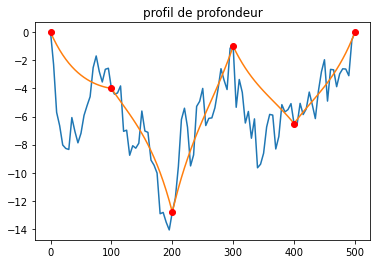

In [3]:
Ec1= mu+np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),depth-mu))

def rejet(Ec):
    positif = True
    Cholesky = np.linalg.cholesky(SigmaCond)
    x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
    simu = Ec1 + np.matmul(Cholesky,x)
    
    while positif :
        simu_neg = np.array(simu<0)
        if  simu_neg.all():
            positif = False
        else :
            x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
            simu = Ec1 + np.matmul(Cholesky,x)
            
    allval5 = np.zeros(N)
    allval5[unknown_indexes]=simu
    allval5[observation_indexes]=depth
        
    return allval5

allval5 = rejet(Ec1)
plt.plot(discretization,allval5)
plt.plot(discretization,allval1)
plt.plot(discretization[observation_indexes], depth, 'ro')
plt.title("profil de profondeur");

On a ainsi un profil de profondeur qui ne présente uniquement des valeurs négatives ce qui est cohérent d'un point de vue physique.

# Question 2:
On cherche donc à calculer la longeur moyenne de cable pour ce nouveau profil. On vaait comme longeur moyenne avant 522,4 m.

In [13]:
print(longeur_moy)

522.4389680368137


In [15]:
K=10000
result_new = np.zeros(K)
for i in range(K):
    allval5 = rejet(Ec1)#à chaque itération on choisi un tracé avec la méthode du rejet
    result_new[i]=length(allval5,Delta)

result_new.mean()
result.mean()

522.4389680368158

La nouvelle moyenne après application de l'algorithme du rejet est de 522,4 aussi, la variation n'est pas très importante.
On trace l'histogramme des longeurs de câbles:

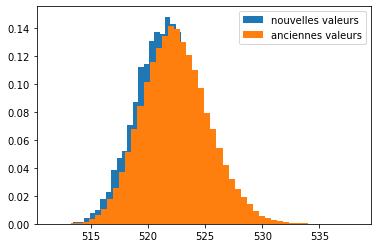

In [16]:
plt.subplots()
axe1 = plt.hist(result_new,50,density=True, label ='nouvelles valeurs')
axe2 = plt.hist(result,50,density = True, label = 'anciennes valeurs')
plt.legend()
plt.show()

On remarque une différence entre les deux histogrammes, les nouvelles valeurs sont en moyenne legèrement plus faibles et moins étalées que les anciennes. On retrouve bien aussi les valeurs moyennes de l'ordre de 522m.
On calcul l'intervalle de confiance par la méthodes des quantiles :

In [17]:
#Vieilles données
Ln = sum(result)/K
sigman = np.std(result)
[Ln - sigman*1.96,Ln + sigman*1.96]

print(np.quantile(result,[0.025,0.975]))

#Nouvelles données
Ln = sum(result_new)/K
sigman = np.std(result_new)
[Ln - sigman*1.96,Ln + sigman*1.96]

print(np.quantile(result_new,[0.025,0.975]))

[517.10356168 528.43915124]
[516.57047279 527.67479751]


On remarque donc ici aussi, comme sur les histogrammes, que les nouvelles valeurs sont moins étalées autour de la moyenne que les anciennes.
Finalement on s'interesse à la probabilité de dépassement d'un seuil de 525m:

In [18]:
print(np.mean(result>525))
print(np.mean(result_new>525))

0.18431
0.129


La probabilité de dépassser une longeur totale de 525 est donc plus faible avec les nouvelles valeurs. 

On calcul le taux de rejet sur 10000 essais

In [19]:
def taux_rejet():
    
    rejet = 1
    positif = True
    Cholesky = np.linalg.cholesky(SigmaCond)
    x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
    simu = Ec + np.matmul(Cholesky,x)
    
    while positif :
        simu_neg = np.array(simu<0)
        if  simu_neg.all():
            positif = False
        else :
            x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
            simu = Ec + np.matmul(Cholesky,x)
            rejet +=1
    return 1/rejet

rejet = 0
for k in range (10000):
    rejet += taux_rejet()
1-rejet/10000

0.8709112530365807

Le taux de rejet est donc d'environ 87%. L'algotithme doit produire de nombbreux essais de simulations avant d'en obtenir une avec aucune valeurs positives.

# Question 3 :

On a :
$$
\begin{align}
f_{z_{OBS},\mu}(z_{OBS},\hat \mu) &= f_{z_{OBS}|\mu = \hat \mu}(z_{OBS})f_{\mu}(\hat \mu) \\
f_{z_{OBS},\mu}(z_{OBS},\hat \mu) &= f_{\mu|z_{OBS}} \\
&= z_{OBS}(\hat \mu)*f_{z_{OBS}}(z_{OBS})
\end{align}
$$
Or on a comme hyposthèse :
$$
z_{OBS}|\mu = \hat \mu  \sim \mathcal{N}(\hat \mu,C_{OBS}) \\
\text{ et } \mu \sim \mathcal{N} (-5,4)
$$
Comme une loi normale admet comme densité la fonction $f(x) = \frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{1}{2}*(\frac{x-\mu}{\sigma})²}$ on peut écrire en passant au logarithme :
$$
-2ln(f_{z_{OBS},\mu}(z_{OBS},\hat \mu)) = (z_{OBS}-1 \hat \mu)^t* C_{OBS}^{-1} *(z_{OBS}-1 \hat \mu) + ( \frac{5+ \hat \mu}{2})²+ ln(8\pi) + ln((2\pi)^6 *det(C_{OBS}))
$$

En prenant les termes en $\hat \mu$:
$$
\hat \mu ²*(1^t C_{OBS}^{-1} *1 + \frac{1}{4}) -2\hat \mu (1^t* C_{OBS}^{-1} * z_{OBS}-\frac{5}{4})
$$
On en déduit que 
$\mu|Z_{OBS}=z_{OBS} \sim \mathcal{N}(\hat \mu,\hat \sigma ²)$ avec $\hat \sigma²= (1^t* C_{OBS}^{-1} * z_{OBS}-\frac{5}{4})^{-1}$
avec $1$ défini comme dans l'ennoncé et $\hat \mu = \hat \sigma ²*(1^t* C_{OBS}^{-1} * z_{OBS}-\frac{5}{4})$

# Question 4 :

On a avec X,Y et Z trois vecteurs aléatoires à densité :
$$ 
\begin{align}
f_{(X,Y)|Z=z}(x,y) &= f_{X|Z=z,Y|Z=z}(x,y) \\
&= \frac{f_{X,Y,Z}(x,y,z)}{f_Z(z)}\\
&= \frac{f_{X,Y,Z}(x,y,z)}{f_{Y,Z}(y,z)} * \frac{f_{Y,Z}(y,z)}{f_Z(z)} \\
f_{(X,Y)|Z=z}(x,y)&= f_{X|Y=y,Z=z}(x)*f_{Y|Z=z}(y)
\end{align}
$$

# Question 5:

Avec l'aide de la question 4 on trouve :
$f_{(Z_{UKN},\mu)|Z_{obs}=z_{obs}} = f_{\mu|Z_{obs}=z_{obs}}* f_{Z_{UKN}|\mu = \mu*, Z_{obs}=z_{obs}}$
en posant :
$$
\left\{ \begin{array}{ll}
        X := Z_{UKN} \\
        Y := \mu \\
        Z := Z_{obs} \\
    \end{array}
    \right.
  $$


Or on sait que $\mu|Z_{obs}=z_{obs} \sim N(\hat \mu, \hat \sigma²)$, donc on a la formule de la fonction de densité d'une gausienne:
$$
f_{\mu|Z_{obs}=z_{obs}}(t) = \frac{1}{\sqrt{2 \pi}* \hat \sigma²}*exp(- \frac{(t-\hat \mu)²}{2 \hat \sigma²})
$$

Pour la deuxième fonction de partition on reconnaît grâce à la partie 1 un vecteur gaussien à densité, de matrice de covariances C dont on peut exprimer la fonction de répartition:
$$
f_{Z_{UKN}|\mu = \mu*, Z_{obs}=z_{obs}} = \frac{1}{(2\pi)^{n/2} \sqrt{det(C)}}*exp(-\frac{1}{2}(x-\mu^*)C^{-1}(x-\mu^*))
$$

La matrice de covariance est bien la même matrice que celle de la partie 1 $C=Sigma$ car dans cette partie on avait fait l'hypothèse que $\mu = \mu^*$

# Question 6:



In [24]:
ones = np.ones(6)
#on calcul avec les formules trouvées avant
var = 1/( np.vdot(ones,np.matmul(np.linalg.inv(SigmaObs),np.transpose(ones))) + 1/4 )

mu_moy = var * (np.vdot(ones, np.matmul(np.linalg.inv(SigmaObs), depth)) - 5/4)

mu_moy, var

(-4.291350330933772, 1.5368909974762894)

# Question 7:
On applique la technique de Box-Muller pour simuler une variable aléatoire gaussienne.

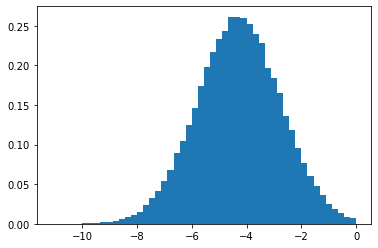

In [20]:
n = 100000 #nombre de points
mu_hat = -4.29
sigma_hat = 1.54

def simu2(n):
    W = np.empty(n)
    i = 0
    while i < n:
        U = np.random.rand(1)
        V = np.random.rand(1)
        X = mu_hat + np.sqrt(-2*np.log(U))*np.cos(2*np.pi*V)*sigma_hat
        if X < 0:
            W[i] = X
            i += 1
    return W
    

plt.hist(simu2(n),50, density = True)
plt.show()

# Question 8:

On génère un couple de $Z_{UNK},\mu|Z_{obs} \text { avec } \mu<0$ grâce aux deux programmes qu'on a écrit plus haut : *simu2* pour générer $\mu$ selon sa loi, puis *rejet* pour simuler $Z_{UKN}$ en prenant en compte la modification de $\mu$.

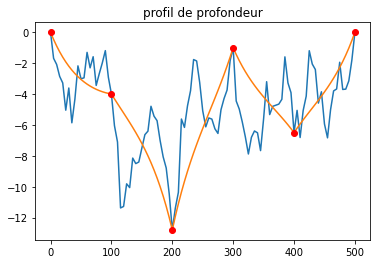

In [116]:
def simu_couple():
    mu = simu2(1)
    Ec2 = mu + np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),depth - mu))
    simu = rejet(Ec2)
    return  simu, mu

simu, mu = simu_couple()
plt.plot(discretization,simu)
plt.plot(discretization,allval1)
plt.plot(discretization[observation_indexes], depth, 'ro')
plt.title("profil de profondeur");


# Question 9:


In [122]:
K=10000
result_new2 = np.zeros(K)
for i in range(K):
    allval5 = rejet(Ec1)
    result_new2[i]=length(allval5,Delta)

result_new2.mean()

521.8150562008716

Pour le convergence:

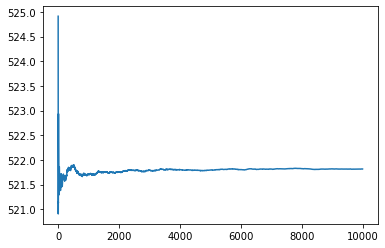

In [123]:
indice_simu = 1+np.arange(K)
plt.plot(indice_simu,np.cumsum(result_new2)/indice_simu)
plt.show()

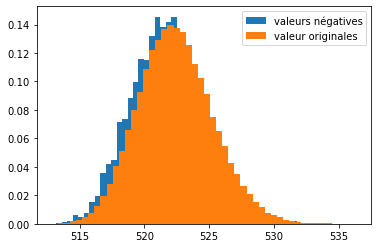

In [124]:
plt.subplots()
axe1 = plt.hist(result_new2,50,density=True, label ='valeurs négatives')
axe2 = plt.hist(result,50,density = True, label = 'valeur originales')
plt.legend()
plt.show()

In [125]:
#Vieilles données
Ln = sum(result)/K
sigman = np.std(result)
[Ln - sigman*1.96,Ln + sigman*1.96]

print(np.quantile(result,[0.025,0.975]))

#Nouvelles données
Ln = sum(result_new2)/K
sigman = np.std(result_new2)
[Ln - sigman*1.96,Ln + sigman*1.96]

print(np.quantile(result_new2,[0.025,0.975]))

[517.11452581 528.40779236]
[516.62715655 527.64963736]


In [126]:
print(np.mean(result>525))
print(np.mean(result_new2>525))

0.18277
0.1338


En simulant pas seulement la profondeur mais aussi $\mu$ on arrive à un profil très similaire de celui obtenu dans la partie 1, en effet on voit sur l'histogramme mais cela est confirmé par les intervalles auntiles et les moyennes, on arrive à simuler de manière très précise les variations de profondeurs. Ainsi simuler $\mu$ n'apporte pas forcement beaucoup plus d'informations.

# Question 10 :
SI on rendait tous les autres paramètres aléatoire, les variations augmenteraient beaucoup et la simulation  pourrait perdre en précision.